## Audience Imact on Game

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# The data files for each league
epl_att_data = "../final-resources/EPL/EPL_scores_attendances.csv"
bun_att_data = "../final-resources/BUN/BUN_scores_attendances.csv"
lig_att_data = "../final-resources/LIG/LIG_scores_attendances.csv"
ser_att_data = "../final-resources/SER/SER_scores_attendances.csv"
images_path = "../images/"

### Setting and Functions for charts


In [31]:
# The following columns will be selected from the dataset
cols = ["Date",
    "HomeTeam",
    "HomeTeam ID", 
    "HomeScore",
    "AwayTeam",
    "AwayTeam ID",
    "AwayScore", 
    "Result",
    "Attendance"]



def Summary(df, league):
    # The total number of matches of the 'league' in 2019-20
    total = len(df['Date'])

    # The number of matches after COVID-19
    Covid_date = "2020-04-01"
    after = len(df.loc[df["Date"] > Covid_date])

    print(f"The number of matches of {league} until {df['Date'].at[total -1]} is {total}")
    print(f"The number of matches of {league} after COVID-19 is {after}")
    return df.describe()


# Plot a horizontal bar chart of average attendance&score for each team 
def Home_Away_Avg_bar_chart(df, league):
    
    # The colors for league: ['Home', 'Away', edgecolor]
    L_colors = {
        "EPL"   : ["crimson","mistyrose","midnightblue"],
        "BUN"   : ["red","gold","silver"],
        "SER"   : ["royalblue","powderblue","silver"],
        "LIG"   : ["orangered","bisque","silver"]}

    # font size for the charts
    font_s = {
        "t" : 20,  #title
        "s" : 18,  #sub title
        'l' : 14 } #label
  
    # Average of data
    avg_df = df.groupby("HomeTeam").mean()
    avg_df = avg_df.sort_values(by="HomeScore")
    
    # home scores and attendances
    home_score = avg_df["HomeScore"]
    home_att = avg_df["Attendance"]    
    teams = avg_df.index

    # Average of away scores, away attendances
    gp_away = df.groupby("AwayTeam")
    away_score = []
    away_att = []
    for team in teams:
        team_away_score = gp_away.get_group(team)["AwayScore"].mean()
        team_away_att = gp_away.get_group(team)["Attendance"].mean()
        away_score.append(team_away_score)
        away_att.append(team_away_att)

    # Bar plot parameters
    bar_h = 2
    alpha = 0.7
    font_s = {
        "t" : 40,  #title
        "s" : 28,  #sub title
        'l' : 18 } #label
    edge_c = L_colors[league][2]
    
    # figure with two subplots
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(30,12), gridspec_kw={'width_ratios': [1, 2]})
    fig.suptitle(league+": Average Scores and Attendances", fontsize=font_s["t"])
    yval = np.arange(len(teams))*6
    
    # ax1 -- scores (horizontal bar from right side)
    ax1.set_title("Home Scores vs. Away Scores", fontsize=font_s["s"])
    x_lim = 0.5 + max(max(home_score), max(away_score))
    ax1.barh(yval-bar_h/2,
             width = home_score,
             left = [x_lim-x for x in home_score], 
             color = L_colors[league][0],
             edgecolor = edge_c,
             alpha = alpha,
             height = bar_h, 
             label = "Home")
    ax1.barh(yval+bar_h/2,
             width = away_score, 
             left = [x_lim-x for x in away_score], 
             color = L_colors[league][1],
             edgecolor = edge_c,
             alpha = alpha,
             height = bar_h, 
             label ="Away")

    ax1.set_xlim(0,x_lim)
    ax1.set_ylim(-4, max(yval)+4)
    ax1.set_xlabel("Avg. Scores", fontsize=font_s["l"])
    ax1.set_yticks([])
    ax1.legend()
                             
    # ax2 -- attendances (horizontal bar from left side)    
    ax2.set_title("Home Attendances vs. Away Attendances", fontsize=font_s["s"])
    ax2.barh(yval-bar_h/2, 
             width = home_att, 
             color = L_colors[league][0],
             edgecolor = edge_c,
             alpha = alpha,
             height = bar_h, 
             label = "Home")
    ax2.barh(yval+bar_h/2, 
             width = away_att, 
             color = L_colors[league][1], 
             edgecolor = edge_c,
             alpha = alpha,
             height = bar_h, 
             label ="Away")

    ax2.set_xlim(0,max(home_att)+1000)
    ax2.set_xlabel("Avg. Attendance", fontsize=font_s["l"])
    ax2.set_ylim(-4, max(yval)+4)
    ax2.set_yticks(yval)
    ax2.set_yticklabels(teams, fontsize=font_s["l"])
    ax2.yaxis.set_label_position("right")
    ax2.legend(fontsize=font_s["l"])
    fig.savefig(f"{images_path}{league}_bar_avg_scores_att.png", bbox_inches='tight')    
    plt.show()
    plt.close(fig)

# Attendances vs. score
# For every match, the total scores (yval) vs. number of audience (xval)
def Att_Score_scatter(df, league):

    # The colors for league: ['Home', 'Away', 'Draw']    
    L_colors = {
        "EPL" : ["crimson","midnightblue","grey"],
        "BUN" : ["red","gold","gray"],
        "SER" : ["royalblue","powderblue","grey"],
        "LIG" : ["orangered","bisque","grey"]}

    # font size for the charts
    font_s = {
        "t" : 20,  #title
        "s" : 18,  #sub title
        'l' : 14 } #label
    
    # figure with three subplots on one axes
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title(f"{league}: Scores vs. Attendances", fontsize=font_s["t"])
    
    # Scatter plot parameters
    wins = ["H", "A", "D"]
    win_label = {"H" : "Hometeam wins",
                 "A" : "Awayteam wins", 
                 "D" : "Draw"}
    win_col = { key:val for key,val in zip(wins, L_colors[league]) }
    win_alpha = {"H" : 1,
                 "A" : 0.7, 
                 "D" : 0.6}
    
    # plot according to the wins = H / A / D
    for win in wins:
        
        # Collect the rows for the 'win'
        win_df = df.loc[df["Result"]==win]

        # xvalue is the attendace of each match
        xval = win_df["Attendance"]
            
        # yvalue is the sum of homescore and awayscore for each match
        yval = win_df["HomeScore"].add(win_df["AwayScore"])
        
        # scatter plot
        ax.scatter(xval, yval, 
                   c = [win_col[win]]*len(xval), 
                   alpha = win_alpha[win], 
                   label = win_label[win])

    ax.set_xlabel("Attendance of a match", fontsize=font_s["l"])
    ax.set_ylabel("Total score of a match", fontsize=font_s["l"])
    ax.legend()
    plt.show()
    fig.savefig(f"{images_path}{league}_scatter_scores_att.png", bbox_inches='tight')
    plt.close(fig)

## England Premier League (EPL)

In [32]:
# Load EPL data and fill na as 0
epl_all_data_df = pd.read_csv(epl_att_data)
epl_df = epl_all_data_df[cols]
epl_df = epl_df.fillna(0)
Summary(epl_df, "EPL")

The number of matches of EPL until 2020-07-13 is 351
The number of matches of EPL after COVID-19 is 62


,HomeScore,AwayScore,Attendance
count,351.000000,351.000000,351.000000
mean,1.518519,1.196581,31438.786325
std,1.239389,1.206454,21452.530864
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,19711.500000
50%,1.000000,1.000000,31108.000000
75%,2.000000,2.000000,51314.000000
max,8.000000,9.000000,73737.000000


### Home score vs. Away score

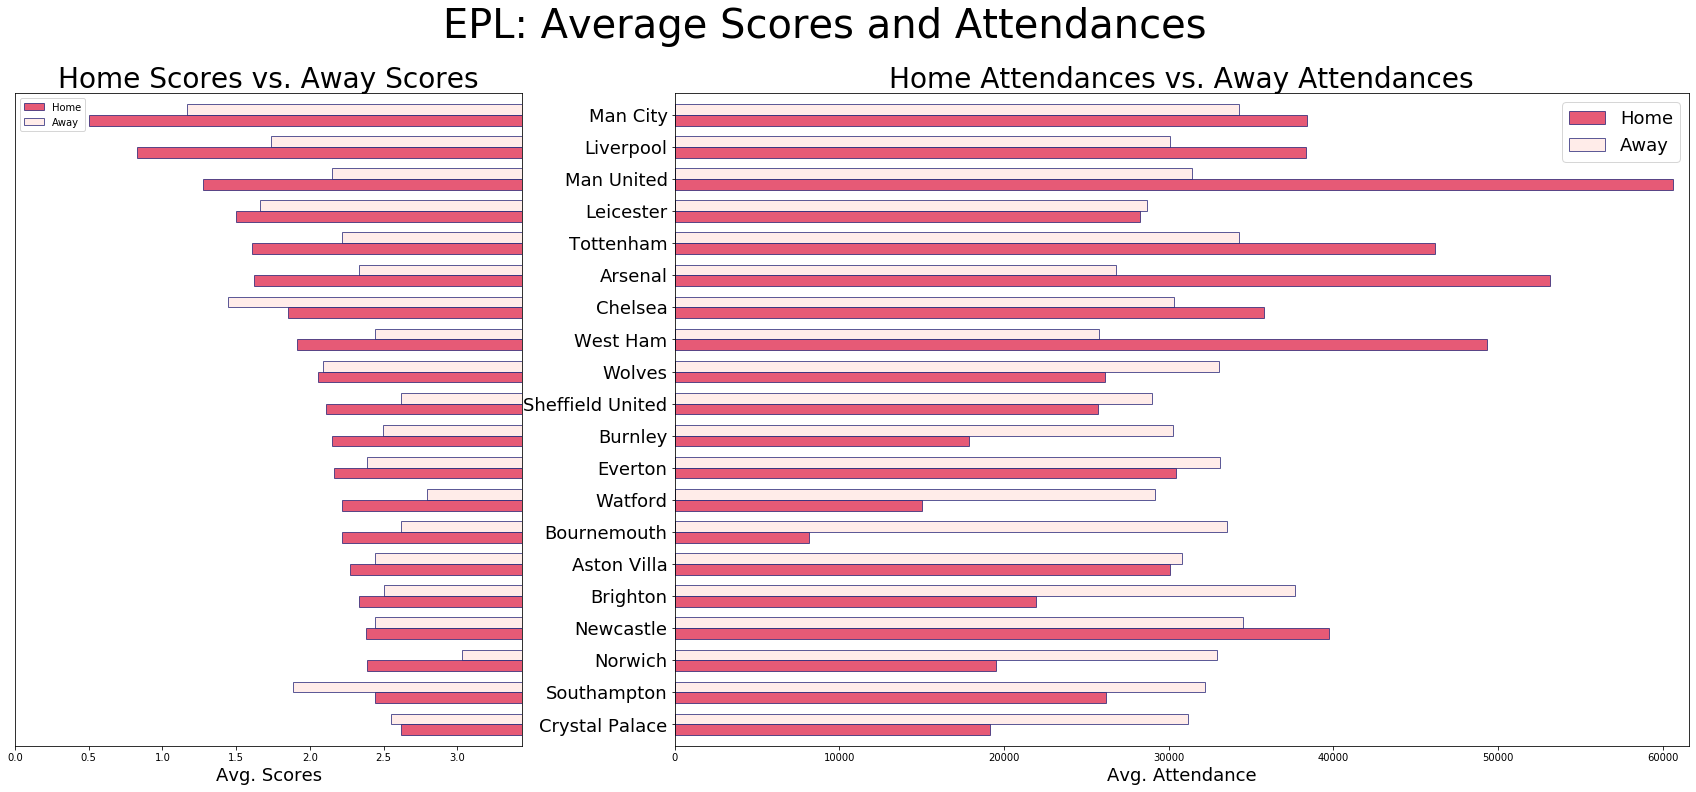

In [33]:
Home_Away_Avg_bar_chart(epl_df, "EPL")

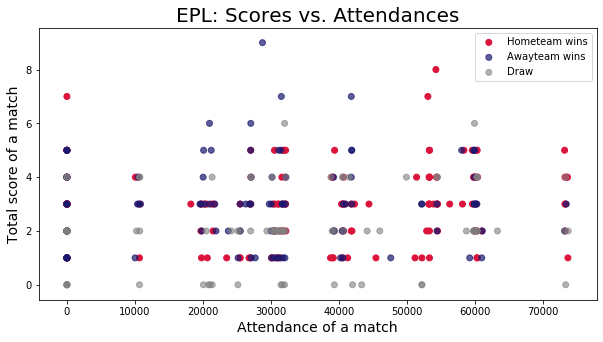

In [34]:
Att_Score_scatter(epl_df, "EPL")